# シミュレーション実習 中間レポート課題の回答



In [ ]:
# Google Colab setup
!pip install numpy==1.22.0
!pip install -U polars seaborn
!pip install sympy

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl

## 第１問

### 1-1

In [ ]:
# define parameterss
d = 8
l_list = [1, 2, 6, 8]

# Generate thera array to plot on graph
theta_array = np.arange(0.01, np.pi/2, np.pi/256)
# Generate y_c array to plot on graph
y_c_array = np.arange(0.01, d/2, d/256)

def condition(l, y_c, theta):
    cond = l * np.cos(theta) / (2 * y_c) > 1
    return cond

def touched_patterns(l, y_c_array, theta_array):
    patterns = []
    for y_c in y_c_array:
        for theta in theta_array:
            if condition(l, y_c, theta):
                patterns.append([l, y_c, theta])
    return patterns

patterns_dict = {l: [] for l in l_list}
print(isinstance(patterns_dict, dict))

True


In [ ]:
# Simulate bar-touch and generate DataFrame of touched paramters patterns
df = pl.DataFrame()
for l in patterns_dict.keys():
    patterns_dict[l] = touched_patterns(l, y_c_array, theta_array)

    df_temp = pl.DataFrame(patterns_dict[l])
    df = df.vstack(df_temp)
df.columns = ['l', 'y_c', 'theta']
print(df.shape)
print(df.head(5))

### 1-1 結果

#### シミュレーションの概要

1. 以下は $d = 8$ としたときの針が棒と交わる $\theta-y_c$ の条件を数値計算した結果である。
1. 針の長さを表す $l$ を [1, 2, 6, 8] の 4 つの場合でシミュレーションした。

#### 結果

1. グラフの通り $l$ が長くなればなるほど針が棒と交わる $\theta, y_c$ の条件が緩くなることがわかる。


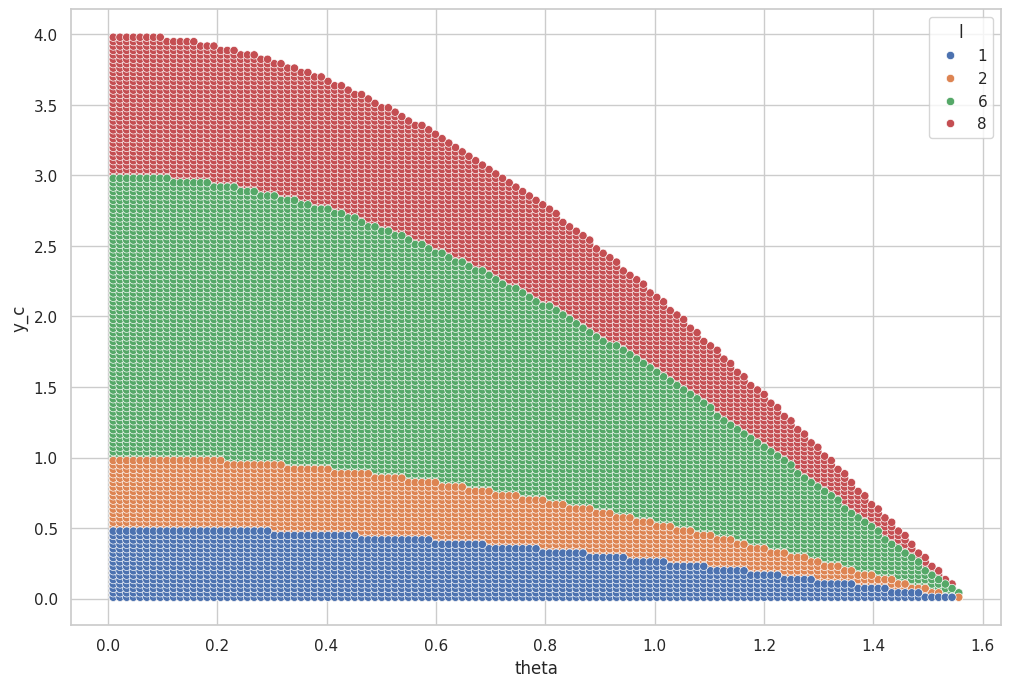

In [ ]:
# Sort by l for displaying
df = df.sort('l', descending=True)
# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='theta', y='y_c', hue='l', palette='deep')
plt.show()


## 1-2

- 棒を落とした時に取りうるθ-y_c 平面上の全領域の面積を s_all
- 1-1 で得られた棒と針が交わる場合の領域の面積を s_touched
とする。
p(l) = s_all / s_touched とすると
p(l) が 棒と針が交わる確率を表せる。

$S_{\text{all}} = d/2 \times \pi/2 = d \times \pi /4$

$S_{\text{touched}}$ は $y_c \le l / 2 \times \cos{\theta}$ を満たす領域の面積。以下のコードブロックで計算する。


In [ ]:
from sympy import *

x = Symbol("x")
l = Symbol("l")
theta = Symbol("theta")
y_c = Symbol("y_c")

s_touched = integrate(l / 2 * cos(theta), (theta, 0, pi/2))
print(s_touched)

l/2


### 1-2 結果

以上の計算より $S_{\text{touched}} = l / 2$

また $S_{\text{all}} = d \pi / 4$ であるから求めたい確率は確かに $p(l) = \frac{2 l}{\pi d}$ となる。

### 1-3
1-2 で求めた確率 p(l) / l = 1/ (pi * d) となるので
y_c, theta の一様乱数を生成して数値的に p(l) の近似値を得れば
1/ (pi *d ) すなわり pi の近似値を得ることができる。


In [ ]:
# Google Colab setup
!nvidia-smi
!pip uninstall -y cupy-cuda12x
!pip install cupy-cuda11x

In [2]:
import cupy as cp
import numpy as np

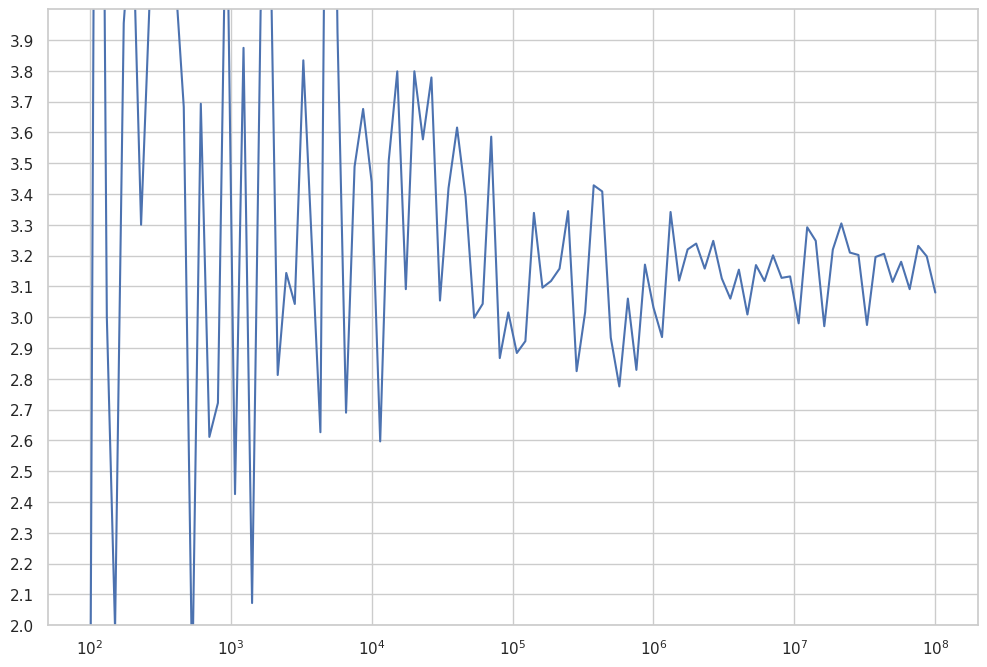

In [6]:
# 高速化のため qupy でGPGPU行列演算させる
def condition(l, y_c, theta):
    return l * cp.cos(theta) / (2 * y_c) > 1

def pi_approxer(d: int, l: int, count_pairs: int = 10**2):
    count_pairs_sqrt = int(np.sqrt(count_pairs))
    theta_array = np.random.uniform(0, np.pi / 2, count_pairs_sqrt).astype(np.float16)
    y_c_array = np.random.uniform(0, d / 2, count_pairs_sqrt).astype(np.float16)

    theta_array = cp.asarray(theta_array, dtype=cp.float16)
    y_c_array = cp.asarray(y_c_array, dtype=cp.float16)

    # Use numpy broadcasting to calculate the condition for all pairs
    touched = condition(l, y_c_array[:, np.newaxis], theta_array)

    # Count the number of True values
    count_touched = np.sum(touched)
    count_all_pairs = count_pairs

    posibility = count_touched / count_all_pairs
    pi = 2 * l / d / posibility
    return pi

count_throw_array = np.logspace(2, 8, 100).astype(int)
pi_array = np.array([pi_approxer(8, 2, count_throw).get() for count_throw in count_throw_array])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x=count_throw_array, y=pi_array)
plt.xscale('log')
plt.yticks(np.arange(2, 4, 0.1))
plt.ylim(2, 4)
# plt.show()
plt.savefig('pi_approximation.png')

### 1-3

以下の画像が 10**2 から 10**8 回 針を落としたシミュレーションで得られた pi の近似値の推移である。

収束速度は遅いが 3.14159... に収束する様子がわかる。

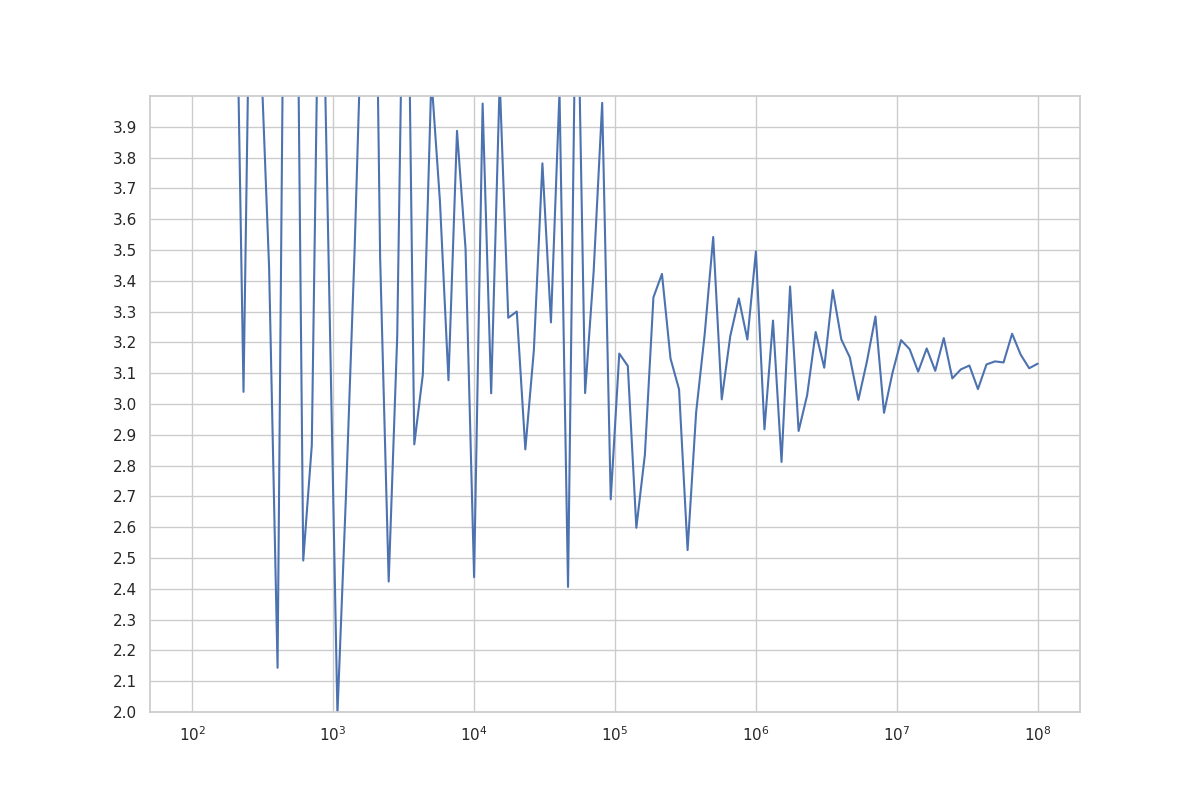

### 1-4

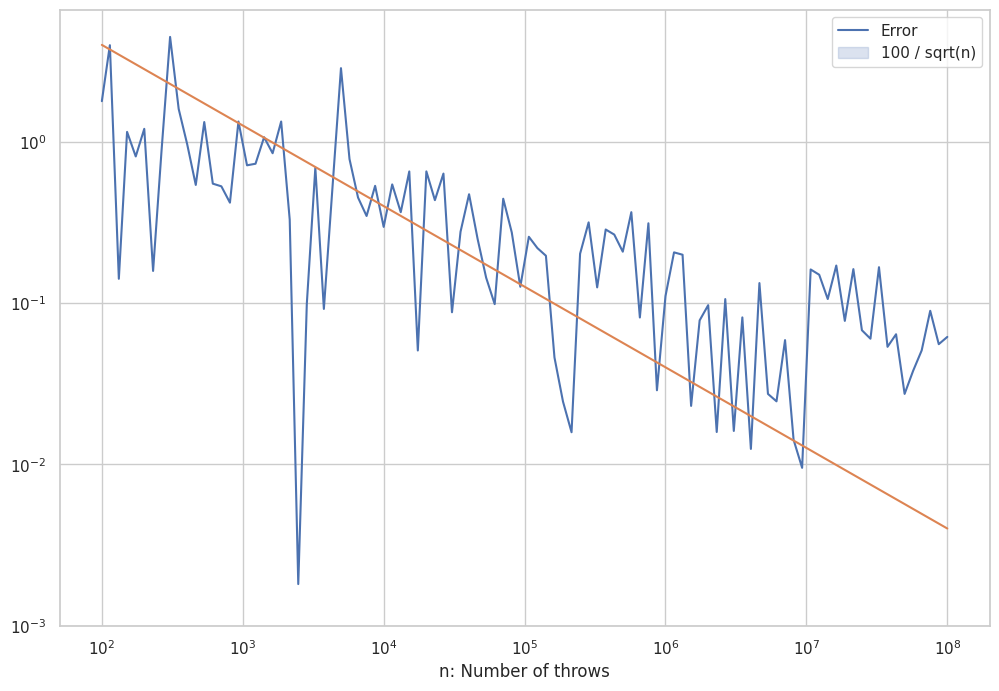

In [7]:
# 試行回数 n と 誤差 error の関係
c_over_root_n = 40 / np.sqrt(count_throw_array)

error_array = np.abs(np.pi - pi_array)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x=count_throw_array, y=error_array)
sns.lineplot(x=count_throw_array, y=c_over_root_n)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n: Number of throws')
plt.yticks(np.logspace(-3, 0, 4))
plt.legend(['Error', '100 / sqrt(n)'])
# plt.ylim(1e-3, 10**2)
# plt.show()
plt.savefig('error_approximation.png')

### 1-4 結果
- 上で行った数値計算の結果 Buffon の針による円周率の近似は誤差収束速度が $\sqrt{N}$ より遅いことがわかった。
- 非効率な円周率計算アルゴリズムと言える。
